In [0]:
import pandas as pd
import string
import nltk
import numpy as np
import sklearn
import seaborn as sns
import re
import json
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection,preprocessing,naive_bayes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from scipy.sparse import hstack
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix

In [112]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [113]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Load Dataset**

In [0]:
train_data=pd.read_csv("/content/drive/My Drive/ML project'20/YelpZip/train_newb.csv")
valid_data=pd.read_csv("/content/drive/My Drive/ML project'20/YelpZip/val_newb.csv")
test_data=pd.read_csv("/content/drive/My Drive/ML project'20/YelpZip/test_newb.csv")

In [115]:
train_data.head()

,user_id,product_id,rating,label,date,review_text,day,year,word_count,punctuation_count,char_count,title_count,user_id_no_of_review,user_id_ave_rating,user_id_ave_no_words,user_id_max_review_a_day,product_id_no_of_review,product_id_ave_rating,product_id_ave_no_of_words,product_id_max_review_a_day
0,192117,3237,4.0,-1,2012-12-30,"delish! pizza was huge, flavorful and filling!...",Sunday,2012,52,8,296,7,1,4.0,52.0,1,114,4.017544,74.684211,14
1,83124,2122,4.0,1,2012-01-21,lava's hummus is better than zahav's. there. i...,Saturday,2012,225,34,1233,21,1,4.0,225.0,1,15,3.666667,140.266667,3
2,137167,3222,2.0,1,2012-08-10,my friend and i decided to come check this pla...,Friday,2012,247,21,1315,11,1,2.0,247.0,1,32,3.500000,82.656250,4
3,51095,523,3.0,1,2012-04-23,oy vey. i really really wanted to write a good...,Monday,2012,210,52,1184,22,1,3.0,210.0,1,18,3.111111,107.611111,6
4,194284,2605,4.0,-1,2012-03-22,i heard about the wait and it was worth it. th...,Thursday,2012,21,4,95,2,2,3.5,25.5,2,117,3.837607,124.427350,15


In [0]:
Days={}
i=1
for val in train_data['day']:
  if val not in Days:
    Days[val]= i
    i+=1
train_data['day']=train_data['day'].apply(lambda x: Days[x])
test_data['day']=test_data['day'].apply(lambda x: Days[x])
valid_data['day']=valid_data['day'].apply(lambda x: Days[x])

In [0]:
X_train=train_data.drop(['user_id','product_id','year','date','label','rating'],axis=1)
y_train=train_data.label
X_test=test_data.drop(['user_id','product_id','year','date','label'],axis=1)
y_test=test_data.label
X_valid=valid_data.drop(['user_id','product_id','year','date','label'],axis=1)
y_valid=valid_data.label

In [0]:
# Normalization
columns=list(X_train.drop(['review_text'],axis=1).columns)
for col in columns:
  X_train[col]=minmax_scale(X_train[col])
for col in columns:
  X_valid[col]=minmax_scale(X_valid[col])
for col in columns:
  X_test[col]=minmax_scale(X_test[col])

In [0]:
pd.set_option('mode.chained_assignment', None)

### **Text Preprocessing**

In [0]:
#Function for expanding all the contractions in the paragraph
with open("/content/drive/My Drive/ML project'20/Contractions.json",'r') as file:
   Contractions=json.load(file)
c_re = re.compile('(%s)' % '|'.join(Contractions.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return Contractions[match.group(0)]
    return c_re.sub(replace, text)

In [0]:
# lowercase,remove digits,punctuations,expand contractions,stopwords and lemmatization
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
X_train['review_text']=X_train['review_text'].apply(lambda x : ''.join([c for c in x if not c.isdigit()])) #Remove numeric digits
X_train['review_text']=X_train['review_text'].apply(lambda x:  ''.join([c for c in x if c not in string.punctuation]))  # Remove punctuations
X_train['review_text']=X_train['review_text'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))

#Val Dataset
X_valid['review_text']=X_valid['review_text'].apply(lambda x : ''.join([c for c in x if not c.isdigit()])) #Remove numeric digits
X_valid['review_text']=X_valid['review_text'].apply(lambda x:  ''.join([c for c in x if c not in string.punctuation]))  # Remove punctuations
X_valid['review_text']=X_valid['review_text'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))

# Test Dataset
X_test['review_text']=X_test['review_text'].apply(lambda x : ''.join([c for c in x if not c.isdigit()])) #Remove numeric digits
X_test['review_text']=X_test['review_text'].apply(lambda x:  ''.join([c for c in x if c not in string.punctuation]))  # Remove punctuations
X_test['review_text']=X_test['review_text'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))

### **Models**

### Classification on review text + features

In [0]:
count_vect_1 = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,1),max_features=5000)
count_vect_1.fit(X_train.review_text)
# vocab=dict(np.ndenumerate(voc[ind]))
feature_vector_train=count_vect_1.transform(X_train.review_text)
feature_vector_test=count_vect_1.transform(X_test.review_text)
feature_vector_valid=count_vect_1.transform(X_valid.review_text)

In [0]:
# Count vectors + Features
feature_vector_train=hstack((feature_vector_train,np.array(X_train["user_id_no_of_review"])[:,None]))
feature_vector_train=hstack((feature_vector_train,np.array(X_train["user_id_ave_rating"])[:,None]))
feature_vector_train=hstack((feature_vector_train,np.array(X_train["user_id_ave_no_words"])[:,None]))
feature_vector_train=hstack((feature_vector_train,np.array(X_train["user_id_max_review_a_day"])[:,None]))
feature_vector_train=hstack((feature_vector_train,np.array(X_train["product_id_no_of_review"])[:,None]))
feature_vector_train=hstack((feature_vector_train,np.array(X_train["product_id_ave_rating"])[:,None]))
feature_vector_train=hstack((feature_vector_train,np.array(X_train["product_id_ave_no_of_words"])[:,None]))
feature_vector_train=hstack((feature_vector_train,np.array(X_train["product_id_max_review_a_day"])[:,None]))
feature_vector_train=hstack((feature_vector_train,np.array(X_train["word_count"])[:,None]))
feature_vector_train=hstack((feature_vector_train,np.array(X_train["punctuation_count"])[:,None]))
feature_vector_train=hstack((feature_vector_train,np.array(X_train["char_count"])[:,None]))
feature_vector_train=hstack((feature_vector_train,np.array(X_train["title_count"])[:,None]))
feature_vector_train=hstack((feature_vector_train,np.array(X_train["day"])[:,None]))

feature_vector_valid=hstack((feature_vector_valid,np.array(X_valid["user_id_no_of_review"])[:,None]))
feature_vector_valid=hstack((feature_vector_valid,np.array(X_valid["user_id_ave_rating"])[:,None]))
feature_vector_valid=hstack((feature_vector_valid,np.array(X_valid["user_id_ave_no_words"])[:,None]))
feature_vector_valid=hstack((feature_vector_valid,np.array(X_valid["user_id_max_review_a_day"])[:,None]))
feature_vector_valid=hstack((feature_vector_valid,np.array(X_valid["product_id_no_of_review"])[:,None]))
feature_vector_valid=hstack((feature_vector_valid,np.array(X_valid["product_id_ave_rating"])[:,None]))
feature_vector_valid=hstack((feature_vector_valid,np.array(X_valid["product_id_ave_no_of_words"])[:,None]))
feature_vector_valid=hstack((feature_vector_valid,np.array(X_valid["product_id_max_review_a_day"])[:,None]))
feature_vector_valid=hstack((feature_vector_valid,np.array(X_valid["word_count"])[:,None]))
feature_vector_valid=hstack((feature_vector_valid,np.array(X_valid["punctuation_count"])[:,None]))
feature_vector_valid=hstack((feature_vector_valid,np.array(X_valid["char_count"])[:,None]))
feature_vector_valid=hstack((feature_vector_valid,np.array(X_valid["title_count"])[:,None]))
feature_vector_valid=hstack((feature_vector_valid,np.array(X_valid["day"])[:,None]))


feature_vector_test=hstack((feature_vector_test,np.array(X_test["user_id_no_of_review"])[:,None]))
feature_vector_test=hstack((feature_vector_test,np.array(X_test["user_id_ave_rating"])[:,None]))
feature_vector_test=hstack((feature_vector_test,np.array(X_test["user_id_ave_no_words"])[:,None]))
feature_vector_test=hstack((feature_vector_test,np.array(X_test["user_id_max_review_a_day"])[:,None]))
feature_vector_test=hstack((feature_vector_test,np.array(X_test["product_id_no_of_review"])[:,None]))
feature_vector_test=hstack((feature_vector_test,np.array(X_test["product_id_ave_rating"])[:,None]))
feature_vector_test=hstack((feature_vector_test,np.array(X_test["product_id_ave_no_of_words"])[:,None]))
feature_vector_test=hstack((feature_vector_test,np.array(X_test["product_id_max_review_a_day"])[:,None]))
feature_vector_test=hstack((feature_vector_test,np.array(X_test["word_count"])[:,None]))
feature_vector_test=hstack((feature_vector_test,np.array(X_test["punctuation_count"])[:,None]))
feature_vector_test=hstack((feature_vector_test,np.array(X_test["char_count"])[:,None]))
feature_vector_test=hstack((feature_vector_test,np.array(X_test["title_count"])[:,None]))
feature_vector_test=hstack((feature_vector_test,np.array(X_test["day"])[:,None]))

In [0]:
NB= naive_bayes.MultinomialNB()
NB.fit(feature_vector_train,y_train.values)
predictions_train=NB.predict(feature_vector_train)
y_test_pred=NB.predict(feature_vector_test)
y_val_pred=NB.predict(feature_vector_valid)

In [147]:
feature_vector_test

<10000x5013 sparse matrix of type '<class 'numpy.float64'>'
	with 492285 stored elements in COOrdinate format>

In [148]:
print('\033[1m'+"Train Dataset Report:\n"+'\033[0m')
print(classification_report(y_train,predictions_train))
print('\033[1m'+"Validation Dataset Report:\n"+'\033[0m')
print(classification_report(y_valid,y_val_pred))
print('\033[1m'+"Test Dataset Report:\n"+'\033[0m')
print(classification_report(y_test,y_test_pred))

Train Dataset Report:

              precision    recall  f1-score   support

          -1       0.69      0.75      0.72     12500
           1       0.73      0.67      0.70     12500

    accuracy                           0.71     25000
   macro avg       0.71      0.71      0.71     25000
weighted avg       0.71      0.71      0.71     25000

Validation Dataset Report:

              precision    recall  f1-score   support

          -1       0.63      0.70      0.66      2500
           1       0.66      0.60      0.63      2500

    accuracy                           0.65      5000
   macro avg       0.65      0.65      0.65      5000
weighted avg       0.65      0.65      0.65      5000

Test Dataset Report:

              precision    recall  f1-score   support

          -1       0.65      0.71      0.68      5000
           1       0.68      0.61      0.64      5000

    accuracy                           0.66     10000
   macro avg       0.66      0.66      0.66     10000
w

In [150]:
print("Accuracy of NB on train dataset : {}%".format(accuracy_score(y_train,predictions_train)*100))
print("Accuracy of NB on validn dataset: {}%".format(accuracy_score(y_valid,y_val_pred)*100))
print("Accuracy of NB on test dataset  : {}%".format(accuracy_score(y_test,y_test_pred)*100))

Accuracy of NB on train dataset : 70.824%
Accuracy of NB on validn dataset: 64.64%
Accuracy of NB on test dataset  : 66.03%


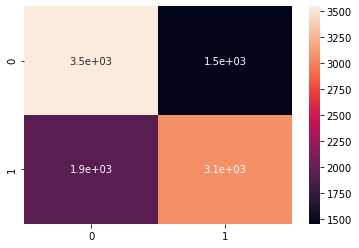

In [151]:
cm=confusion_matrix(y_test,y_test_pred)
sns.heatmap(cm,annot=True)

### Classification on review text

In [0]:
#Count Vectorizer for day
# count_vect_=CountVectorizer(analyzer='word')
# count_vect_.fit(X_train.day)
# feat=1000
count_vect_1 = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,1),max_features=5000)
count_vect_1.fit(X_train.review_text)
feature_vector_train=count_vect_1.transform(X_train.review_text)
# feature_vector_train=feature_vector_train[:,ind]
feature_vector_test=count_vect_1.transform(X_test.review_text)
# feature_vector_test=feature_vector_test[:,ind]
feature_vector_valid=count_vect_1.transform(X_valid.review_text)
# feature_vector_valid=feature_vector_valid[:,ind]

In [0]:
NB= naive_bayes.MultinomialNB()
NB.fit(feature_vector_train,y_train.values)
predictions_train=NB.predict(feature_vector_train)
y_test_pred=NB.predict(feature_vector_test)
y_val_pred=NB.predict(feature_vector_valid)

In [154]:
print('\033[1m'+"Train Dataset Report:\n"+'\033[0m')
print(classification_report(y_train,predictions_train))
print('\033[1m'+"Validation Dataset Report:\n"+'\033[0m')
print(classification_report(y_valid,y_val_pred))
print('\033[1m'+"Test Dataset Report:\n"+'\033[0m')
print(classification_report(y_test,y_test_pred))

Train Dataset Report:

              precision    recall  f1-score   support

          -1       0.69      0.72      0.71     12500
           1       0.71      0.68      0.69     12500

    accuracy                           0.70     25000
   macro avg       0.70      0.70      0.70     25000
weighted avg       0.70      0.70      0.70     25000

Validation Dataset Report:

              precision    recall  f1-score   support

          -1       0.63      0.67      0.65      2500
           1       0.65      0.61      0.63      2500

    accuracy                           0.64      5000
   macro avg       0.64      0.64      0.64      5000
weighted avg       0.64      0.64      0.64      5000

Test Dataset Report:

              precision    recall  f1-score   support

          -1       0.65      0.68      0.66      5000
           1       0.66      0.63      0.65      5000

    accuracy                           0.66     10000
   macro avg       0.66      0.66      0.66     10000
w

In [155]:
print("Accuracy of NB on train dataset : {}%".format(accuracy_score(y_train,predictions_train)*100))
print("Accuracy of NB on validn dataset: {}%".format(accuracy_score(y_valid,y_val_pred)*100))
print("Accuracy of NB on test dataset  : {}%".format(accuracy_score(y_test,y_test_pred)*100))

Accuracy of NB on train dataset : 70.08%
Accuracy of NB on validn dataset: 64.2%
Accuracy of NB on test dataset  : 65.59%


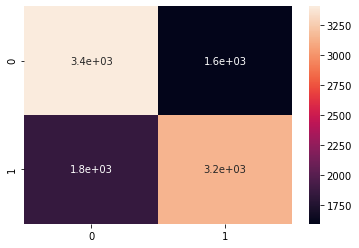

In [156]:
cm=confusion_matrix(y_test,y_test_pred)
sns.heatmap(cm,annot=True)